<a href="https://colab.research.google.com/github/Frandiiile/Quants/blob/main/Pricing_Asian_Options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The main goal of this notebook is to show how pricing can be done on options and show the differene between different methods.


# Monte Carlo Pricing of European arithmetic Asian options
We will investigate the Monte Carlo simulation method for use in valuing financial derivatives. The mathematic notation and examples are from Les Clewlow and Chris Strickland’s book Implementing Derivatives Models.


Valuation of Financial Derivatives through Monte Carlo Simulations is only possible by using the Financial Mathematics of Risk-Neutral Pricing and simulating risk-neutral asset paths.

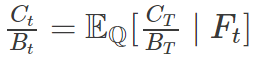



In [1]:
# Importing Libraries
import time
import numpy as np
import pandas as pd
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt

# Path-Dependent Options – Asian Options

We are pricing a European arithmetic Asian call option. The option pays the difference between the arithmetic average of the asset price AT and the strike price K at the maturity date T. The arithmetic average is taken on a set of observations of the asset price STi which we assume follows a GBM at dates ti=1,…,N

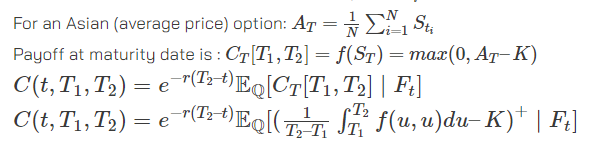





# Initial Parameters
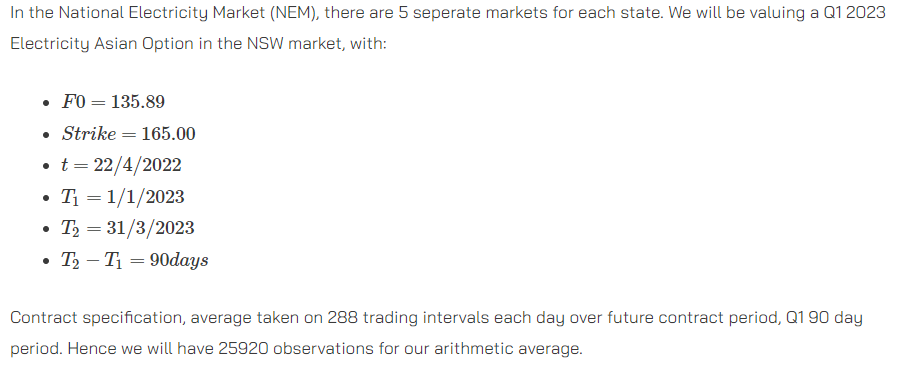


In [2]:
t = datetime(2022,4,22)
T1 = datetime(2023,1,1)
T2 = datetime(2023,3,31)
Q123_days = ((T2 - T1).days+1)
# Initialise parameters
S0 = 135.89               # initial stock price
K = 165.00                # strike price
T = ((T2-t).days)/365     # time to maturity in years
r = 0.0                   # annual risk-free rate
vol = 0.5307              # volatility (%)
N = Q123_days*288         # number of time steps
M = 1000                  # number of simulations
Q123_days, N

(90, 25920)

# Black Scholes

In [3]:
def blackScholes(r, S, K, T, sigma, type="c"):
    "Calculate BS price of call/put"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    try:
        if type == "c":
            price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        elif type == "p":
            price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)
        return price
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")
print("Black Scholes Option Price: ", round(blackScholes(r, S0, K, T, vol, "c"),2))

Black Scholes Option Price:  18.08


# Demonstration of pricing
let’s trade OTC, a bespoke Average Rate Option over Q123 with the underlying as the futures contract.
Let’s say that the average rate option prices are determined by the average of the (closing) daily futures prices across the Q123 period.  

# Fast Estimate

In [5]:
N = Q123_days
T_tT2 = ((T2-t).days+1)/365
T_tT1 = (T1-t).days/365
obs_times = np.linspace(T_tT1,T_tT2,N+1)
# Include starting time, uneven time delta's
obs_times[0]=0
dt = np.diff(obs_times)
print("Number of time steps:", len(dt))
start_time = time.time()
nudt = np.full(shape=(N,M), fill_value=0.0)
volsdt = np.full(shape=(N,M), fill_value=0.0)
# Precompute constants
for i in range(N):
    nudt[i,:] = (r - 0.5*vol**2)*dt[i]
    volsdt[i,:] = vol*np.sqrt(dt[i])
# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S0*np.cumprod( np.exp(delta_St), axis=0)
AT = np.cumsum(ST, axis=0)/N
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S0), ST ) )
CT = np.maximum(0, AT[-1] - K)
C0_fast = np.exp(-r*T)*np.sum(CT)/M
sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_fast)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_fast = sigma/np.sqrt(M)
time_comp_fast = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_fast,3),np.round(SE_fast,3)))
print("Computation time is: ", time_comp_fast)

Number of time steps: 90
Call value is $13.782 with SE +/- 1.214
Computation time is:  0.0237


# There is no analytical solution for an arithmetic Asian option, however there is for a geometric Asian option.


In [6]:
def discrete_geometric_asian(K, dt, S, vol, r, N):
    n, h, j = len(dt), dt[-1], 0
    T = np.cumsum(dt)[-1]
    T1nj = (T-(n-j-1)*h/2)*(n-j)/n
    T2nj = T*((n-j)/n)**2 - (n-j)*(n-j-1)*(4*n-4*j+1)*h/(6*n**2)
    Bj = (np.cumprod(np.array([(S*T - (n-j)*h)/S for j in range(1,n+1)]))[-1])**(1/n)
    Bj = 1 # no oberservations past
    Aj = Bj*np.exp(-r*(T-T1nj)-0.5*vol**2*(T2nj-T1nj))
    dnj = (np.log(S/K)+(r-0.5*vol**2)*T1nj + np.log(Bj))/(vol*np.sqrt(T2nj))
    C = S*Aj*norm.cdf(dnj + vol*np.sqrt(T2nj), 0, 1) - K*np.exp(-r*T)*norm.cdf(dnj)
    return C

discrete_geometric_asian(K, dt, S0, vol, r, N)

15.948956205008614

# With geometric control variate

In [7]:
start_time = time.time()
nudt = np.full(shape=(N,M), fill_value=0.0)
volsdt = np.full(shape=(N,M), fill_value=0.0)
# Precompute constants
for i in range(N):
    nudt[i,:] = (r - 0.5*vol**2)*dt[i]
    volsdt[i,:] = vol*np.sqrt(dt[i])
# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St = nudt + volsdt*Z
ST = S0*np.cumprod( np.exp(delta_St), axis=0)
AT = np.cumsum(ST, axis=0)/N
GT = np.cumprod(ST**(1/N), axis=0)
CT = np.maximum(0, AT[-1] - K) - np.maximum(0, GT[-1] - K)
C0_cv = np.exp(-r*T)*np.sum(CT)/M
sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_cv)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_cv = sigma/np.sqrt(M)
C0_cv += discrete_geometric_asian(K, dt, S0, vol, r, N)
time_comp_cv = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_cv,3),np.round(SE_cv,3)))
print("Computation time is: ", time_comp_cv)

Call value is $16.256 with SE +/- 0.024
Computation time is:  0.0318


# With antithetic and control variates

In [8]:
start_time = time.time()
nudt = np.full(shape=(N,M), fill_value=0.0)
volsdt = np.full(shape=(N,M), fill_value=0.0)
# Precompute constants
for i in range(N):
    nudt[i,:] = (r - 0.5*vol**2)*dt[i]
    volsdt[i,:] = vol*np.sqrt(dt[i])
# Monte Carlo Method
Z = np.random.normal(size=(N, M))
delta_St1 = nudt + volsdt*Z
delta_St2 = nudt - volsdt*Z
ST1 = S0*np.cumprod( np.exp(delta_St1), axis=0)
ST2 = S0*np.cumprod( np.exp(delta_St2), axis=0)
AT1 = np.cumsum(ST1, axis=0)/N
AT2 = np.cumsum(ST2, axis=0)/N
GT1 = np.cumprod(ST1**(1/N), axis=0)
GT2 = np.cumprod(ST2**(1/N), axis=0)
CT = 0.5 * ( np.maximum(0, AT1[-1] - K) - np.maximum(0, GT1[-1] - K)
            + np.maximum(0, AT2[-1] - K) - np.maximum(0, GT2[-1] - K))
C0_acv = np.exp(-r*T)*np.sum(CT)/M
sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0_acv)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE_acv = sigma/np.sqrt(M)
C0_acv += discrete_geometric_asian(K, dt, S0, vol, r, N)
time_comp_acv = round(time.time() - start_time,4)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0_acv,3),np.round(SE_acv,3)))
print("Computation time is: ", time_comp_acv)

Call value is $16.292 with SE +/- 0.02
Computation time is:  0.0365


In [10]:
C0_variates = [C0_fast, C0_cv, C0_acv]
se_variates = [ SE_fast,SE_cv, SE_acv]
se_red = [round(SE_fast/se,2) for se in se_variates]
comp_time = [time_comp_fast,time_comp_cv, time_comp_acv]
rel_time = [round(mc_time/time_comp_fast,2) for mc_time in comp_time]
data = {'Asian Call Option Value': np.round(C0_variates,3),
        'Standard Error SE': np.round(se_variates,3),
        'SE Reduction Multiple': se_red,
        'Relative Computation Time': rel_time}

# Creates pandas DataFrame.
df = pd.DataFrame(data, index =[ 'Fast Estimate',
'with geometric control variate', 'with antithetic and control variates'])
df

,Asian Call Option Value,Standard Error SE,SE Reduction Multiple,Relative Computation Time
Fast Estimate,13.782,1.214,1.00,1.00
with geometric control variate,16.256,0.024,50.24,1.34
with antithetic and control variates,16.292,0.020,59.67,1.54


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Asian Call Option Value'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Standard Error SE'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['SE Reduction Multiple'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df, *['Relative Computation Time'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Asian Call Option Value'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Standard Error SE'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['SE Reduction Multiple'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df, *['Relative Computation Time'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 10 * figscale, 10 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df, *[[['Asian Call Option Value', 'Standard Error SE'], ['Standard Error SE', 'SE Reduction Multiple'], ['SE Reduction Multiple', 'Relative Computation Time']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['Asian Call Option Value', 'Standard Error SE', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['Asian Call Option Value', 'count()', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['SE Reduction Multiple', 'Standard Error SE', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(df, *['SE Reduction Multiple', 'count()', None], **{})
chart